### Importação das Bibliotecas

In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scikeras.wrappers import KerasRegressor

from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.metrics import RootMeanSquaredError

In [47]:
def create_sequences_uni(data=[], seq_len=7):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

In [48]:
def create_lstm_model(seq_len=14, n_features=1, neurons=100, drop=0.2, optimizer='Adam'):
  model = Sequential([
      Input(shape=(seq_len, n_features)),
      LSTM(neurons, return_sequences=True),
      Dropout(drop),
      LSTM((neurons//2), return_sequences=False),
      Dropout(drop),
      Dense(1),
  ])
  model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
  return model

param_grid = {
                'model__neurons': [32, 64, 96],
                'model__drop': [0.1, 0.2, 0.3],
                'model__optimizer': ['Adam'], 
                'fit__batch_size': [16, 32],   
                'fit__epochs': [50, 100],
                # 'model__neurons': [40],
                # 'model__drop': [0.1],
                # 'model__optimizer': ['Adam'], 
                # 'fit__batch_size': [16],   
                # 'fit__epochs': [50],
              }

In [49]:
models_lstm_all = []
models_lstm_cropped = []
models_lstm_lag_all = []
models_lstm_lag_cropped = []
seq_len_options = [7, 14, 30]
# seq_len_options = [7]
split_options = [5, 10]
# split_options = [5]

event_date = pd.Timestamp('2024-11-05') 
event_label = "Trump Elected"

### Modelo com dado completo

In [50]:
data = pd.read_csv('../../data/processed/ETH-USD_all.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume
Date,,,,,
2017-11-09,320.884003,329.451996,307.056000,308.644989,893249984
2017-11-10,299.252991,324.717987,294.541992,320.670990,885985984
2017-11-11,314.681000,319.453003,298.191986,298.585999,842300992
2017-11-12,307.907990,319.153015,298.513000,314.690002,1613479936
2017-11-13,316.716003,328.415009,307.024994,307.024994,1041889984


In [51]:
serie = data['Close']

train_size = int(0.8 * len(serie))
train_data = serie[:train_size].values.reshape(-1, 1)
test_data = serie[train_size:].values.reshape(-1, 1)

scaler_all = MinMaxScaler(feature_range=(0,1))
data_train_scaled = scaler_all.fit_transform(train_data)
data_test_scaled = scaler_all.transform(test_data)

In [52]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_train_scaled, y_train_scaled = create_sequences_uni(data_train_scaled, seq_len)
  X_test_scaled, y_test_scaled = create_sequences_uni(data_test_scaled, seq_len)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result_all = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_all.append({
      "model": grid_result_all.best_estimator_,
      "params": grid_result_all.best_params_,
      "rmse": -grid_result_all.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "X_test": X_test_scaled,
      "y_test": y_test_scaled,
      "type": "Univariado",
      "algorithm": "LSTM"
    })
    
    print(f"Menor RMSE: {-grid_result_all.best_score_:.3f} usando: {grid_result_all.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.019 usando: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.018 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 64, 'model__optimizer': 'Adam'}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.018 usando: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.018 usando: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.018 usando: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.018 usando: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}


#### Resultados


In [53]:
for m in models_lstm_all:
    y_pred = m["model"].predict(m["X_test"])
    rmse_test = np.sqrt(mean_squared_error(m["y_test"], y_pred))
    m["rmse_test"] = rmse_test

lstm_all_ordered_by_test = sorted(models_lstm_all, key=lambda x: x["rmse_test"])

for i, obj in enumerate(lstm_all_ordered_by_test):
    print(f"--- Modelo {i+1} ---")
    print("params:", obj.get("params"))
    print("rmse_test:", obj.get("rmse_test"))
    print("n_splits:", obj.get("n_splits"))
    print("seq_len:", obj.get("seq_len"))
    print()

--- Modelo 1 ---
params: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.024605961467162138
n_splits: 10
seq_len: 30

--- Modelo 2 ---
params: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.02649130167664816
n_splits: 5
seq_len: 7

--- Modelo 3 ---
params: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.026735408811630414
n_splits: 5
seq_len: 14

--- Modelo 4 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 64, 'model__optimizer': 'Adam'}
rmse_test: 0.027436989324614545
n_splits: 10
seq_len: 7

--- Modelo 5 ---
params: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.029331765937506925
n_splits: 5
seq_len: 30

--- Modelo 6 ---
para

In [54]:
y_pred_scaled = lstm_all_ordered_by_test[0]["model"].predict(lstm_all_ordered_by_test[0]["X_test"])

rmse = np.sqrt(mean_squared_error(lstm_all_ordered_by_test[0]["y_test"], y_pred_scaled))
mae = mean_absolute_error(lstm_all_ordered_by_test[0]["y_test"], y_pred_scaled)

print(f"MAE normalizado: {mae}")
print(f"RMSE normalizado: {rmse}")

y_pred = scaler_all.inverse_transform(y_pred_scaled)
y_test = scaler_all.inverse_transform(lstm_all_ordered_by_test[0]["y_test"])

MAE normalizado: 0.01736047320093579
RMSE normalizado: 0.024605961467162138


In [55]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE real: {mae}")
print(f"RMSE real: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE real: 82.07648169476053
RMSE real: 116.33155434448004
MAPE: 2.77%
R²: 0.98


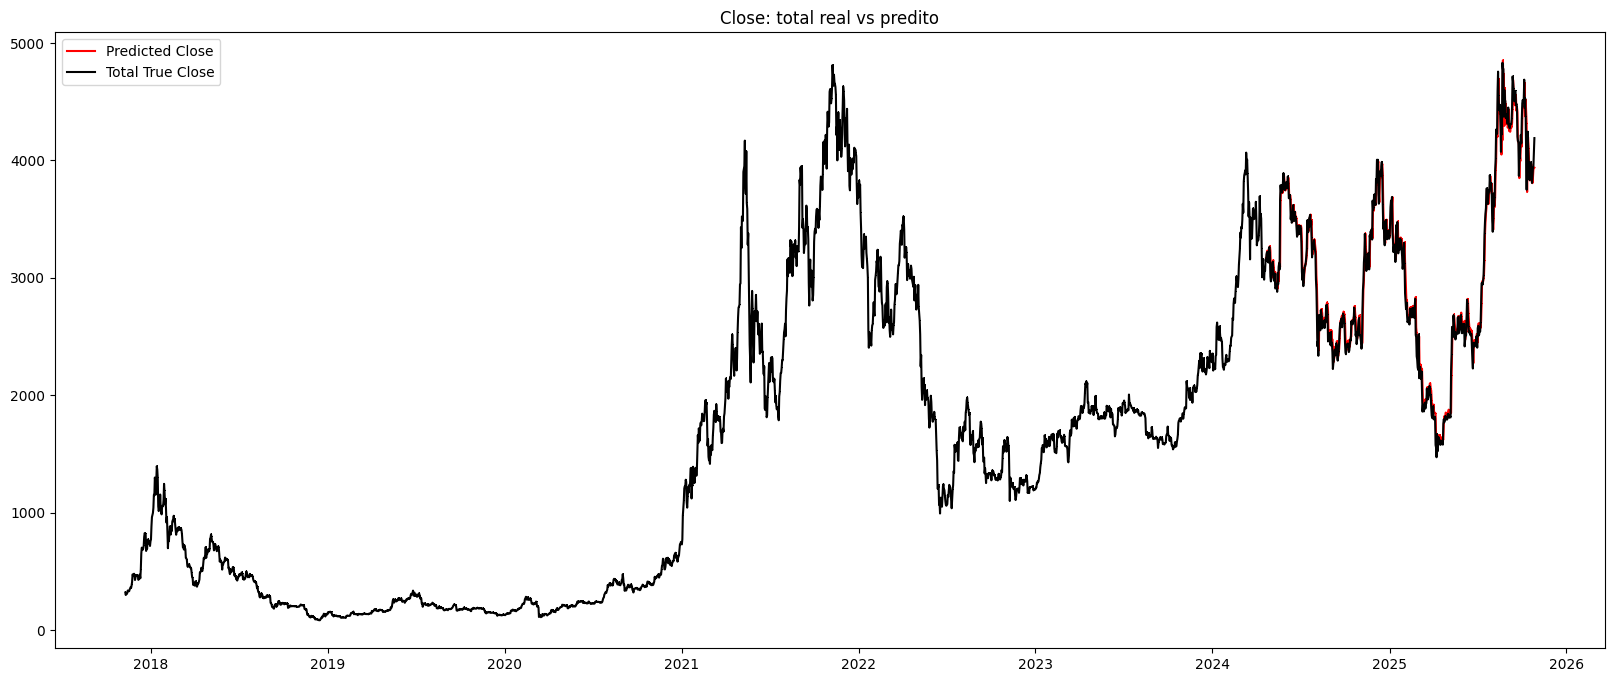

In [56]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

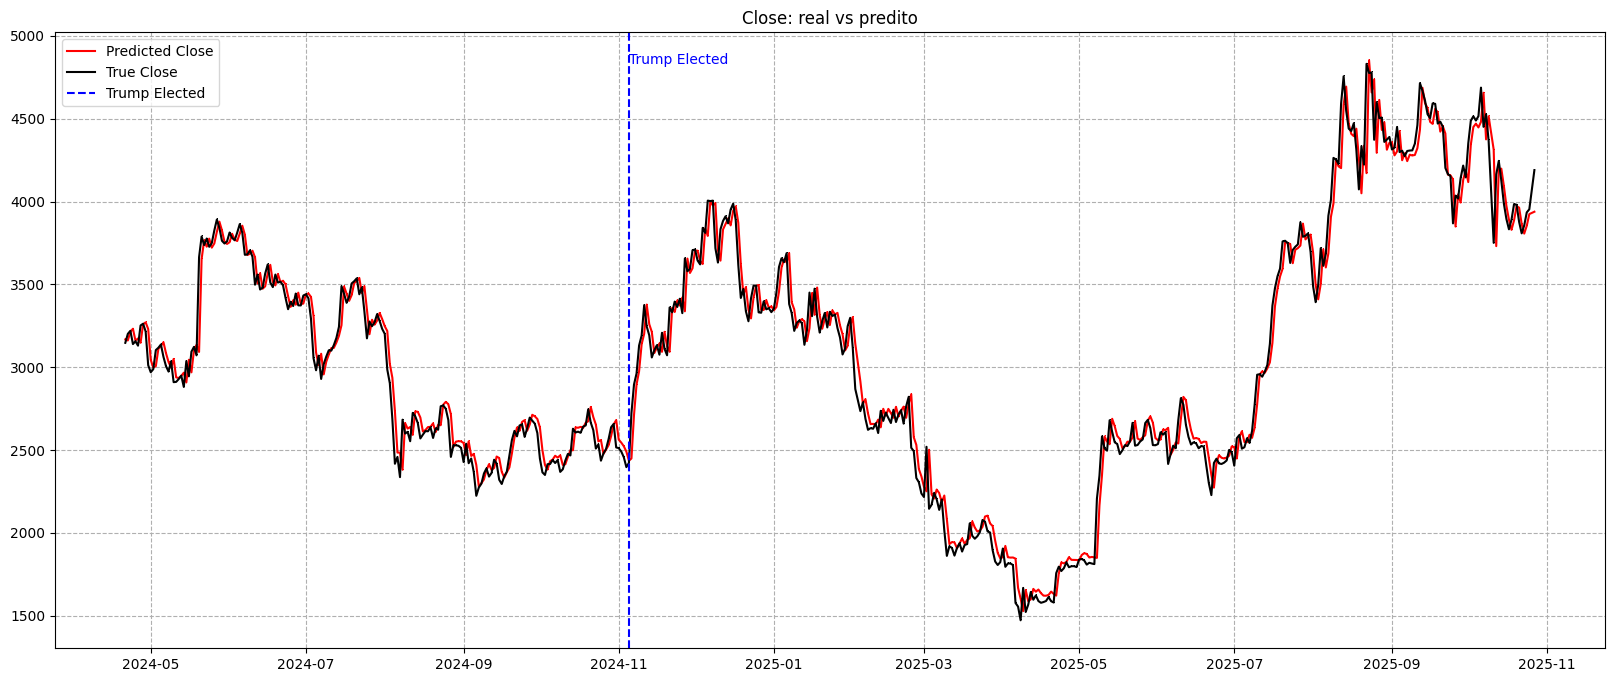

In [57]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date, color='blue', linestyle='--', label=event_label)
plt.text(event_date, max(data['Close']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

### Modelo com dado cortado (inicio ate a moeda se estabilizar foi removido)

In [58]:
data = pd.read_csv('../../data/processed/ETH-USD_cropped.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume
Date,,,,,
2020-06-01,246.991760,248.236282,230.488052,230.860260,13951727936
2020-06-02,237.219055,252.222000,233.225296,246.828186,13782107567
2020-06-03,244.179321,244.179321,235.464447,237.395218,9861760817
2020-06-04,244.426392,245.928970,236.765305,244.105286,10170414304
2020-06-05,241.221985,247.329498,240.682053,244.349594,9293963914


In [59]:
serie = data['Close']

train_size = int(0.8 * len(serie))
train_data = serie[:train_size].values.reshape(-1, 1)
test_data = serie[train_size:].values.reshape(-1, 1)

scaler_cropped = MinMaxScaler(feature_range=(0,1))
data_train_scaled = scaler_cropped.fit_transform(train_data)
data_test_scaled = scaler_cropped.transform(test_data)

In [60]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_train_scaled, y_train_scaled = create_sequences_uni(data_train_scaled, seq_len)
  X_test_scaled, y_test_scaled = create_sequences_uni(data_test_scaled, seq_len)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result_cropped = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_cropped.append({
      "model": grid_result_cropped.best_estimator_,
      "params": grid_result_cropped.best_params_,
      "rmse": -grid_result_cropped.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "X_test": X_test_scaled,
      "y_test": y_test_scaled,
      "type": "Univariado",
      "algorithm": "LSTM"
    })
    
    print(f"Menor RMSE: {-grid_result_cropped.best_score_:.3f} usando: {grid_result_cropped.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.042 usando: {'fit__batch_size': 32, 'fit__epochs': 50, 'model__drop': 0.3, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.027 usando: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.101 usando: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.3, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.027 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.031 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.027 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}


#### Resultados

In [61]:
for m in models_lstm_cropped:
    y_pred = m["model"].predict(m["X_test"])
    rmse_test = np.sqrt(mean_squared_error(m["y_test"], y_pred))
    m["rmse_test"] = rmse_test

lstm_cropped_ordered_by_test = sorted(models_lstm_cropped, key=lambda x: x["rmse_test"])

for i, obj in enumerate(lstm_cropped_ordered_by_test):
    print(f"--- Modelo {i+1} ---")
    print("params:", obj.get("params"))
    print("rmse_test:", obj.get("rmse_test"))
    print("n_splits:", obj.get("n_splits"))
    print("seq_len:", obj.get("seq_len"))
    print()

--- Modelo 1 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.027747490419393023
n_splits: 10
seq_len: 30

--- Modelo 2 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.027773533910844254
n_splits: 5
seq_len: 30

--- Modelo 3 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.028234695665124907
n_splits: 10
seq_len: 14

--- Modelo 4 ---
params: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.028894566495734873
n_splits: 10
seq_len: 7

--- Modelo 5 ---
params: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.3, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.029923632251240704
n_splits: 5
seq_len: 14

--- Modelo 6 ---
pa

In [62]:
y_pred_scaled = lstm_cropped_ordered_by_test[0]["model"].predict(lstm_cropped_ordered_by_test[0]["X_test"])

rmse = np.sqrt(mean_squared_error(lstm_cropped_ordered_by_test[0]["y_test"], y_pred_scaled))
mae = mean_absolute_error(lstm_cropped_ordered_by_test[0]["y_test"], y_pred_scaled)

print(f"MAE normalizado: {mae}")
print(f"RMSE normalizado: {rmse}")

y_pred = scaler_cropped.inverse_transform(y_pred_scaled)
y_test = scaler_cropped.inverse_transform(lstm_cropped_ordered_by_test[0]["y_test"])

MAE normalizado: 0.01952800520042609
RMSE normalizado: 0.027747490419393023


In [63]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE real: {mae}")
print(f"RMSE real: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE real: 89.61651929045378
RMSE real: 127.33678575580063
MAPE: 2.90%
R²: 0.98


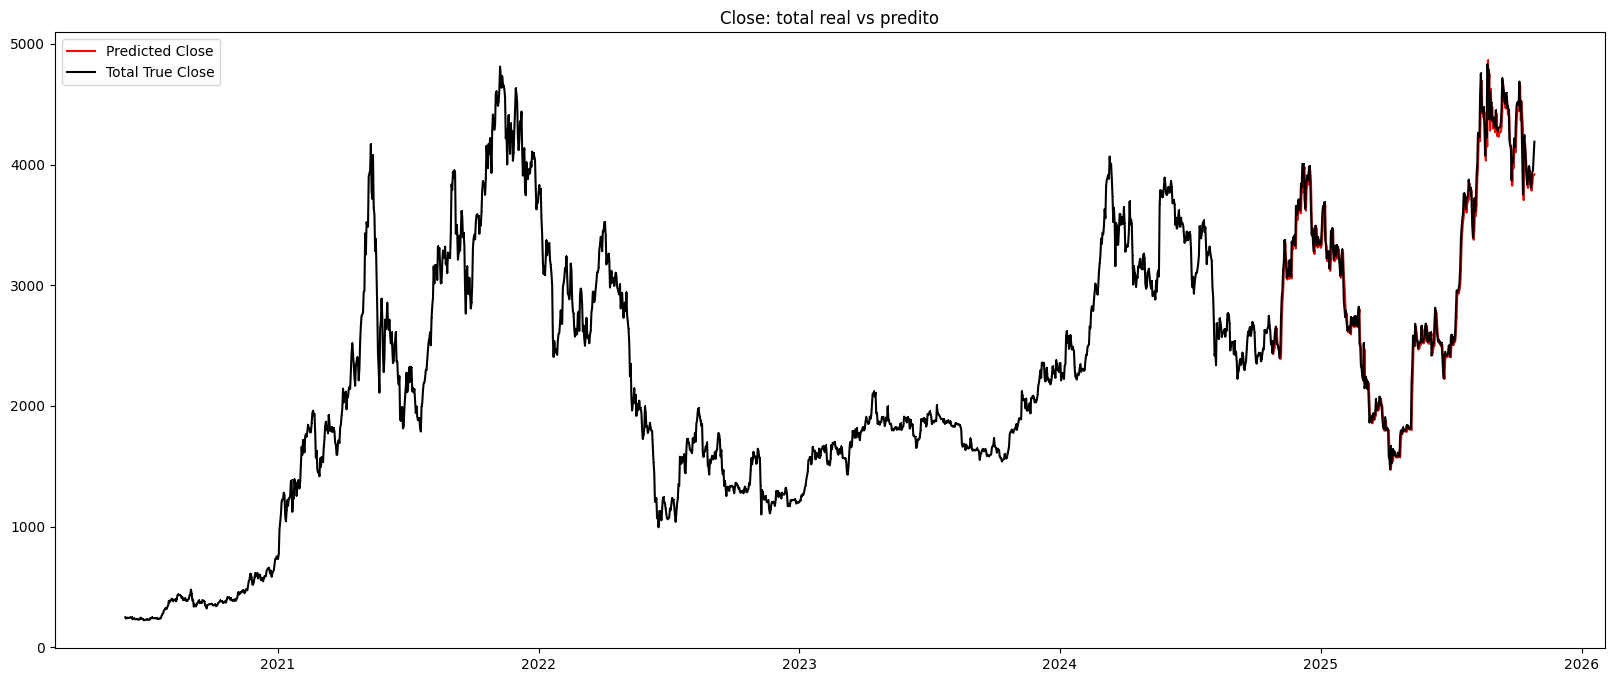

In [64]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

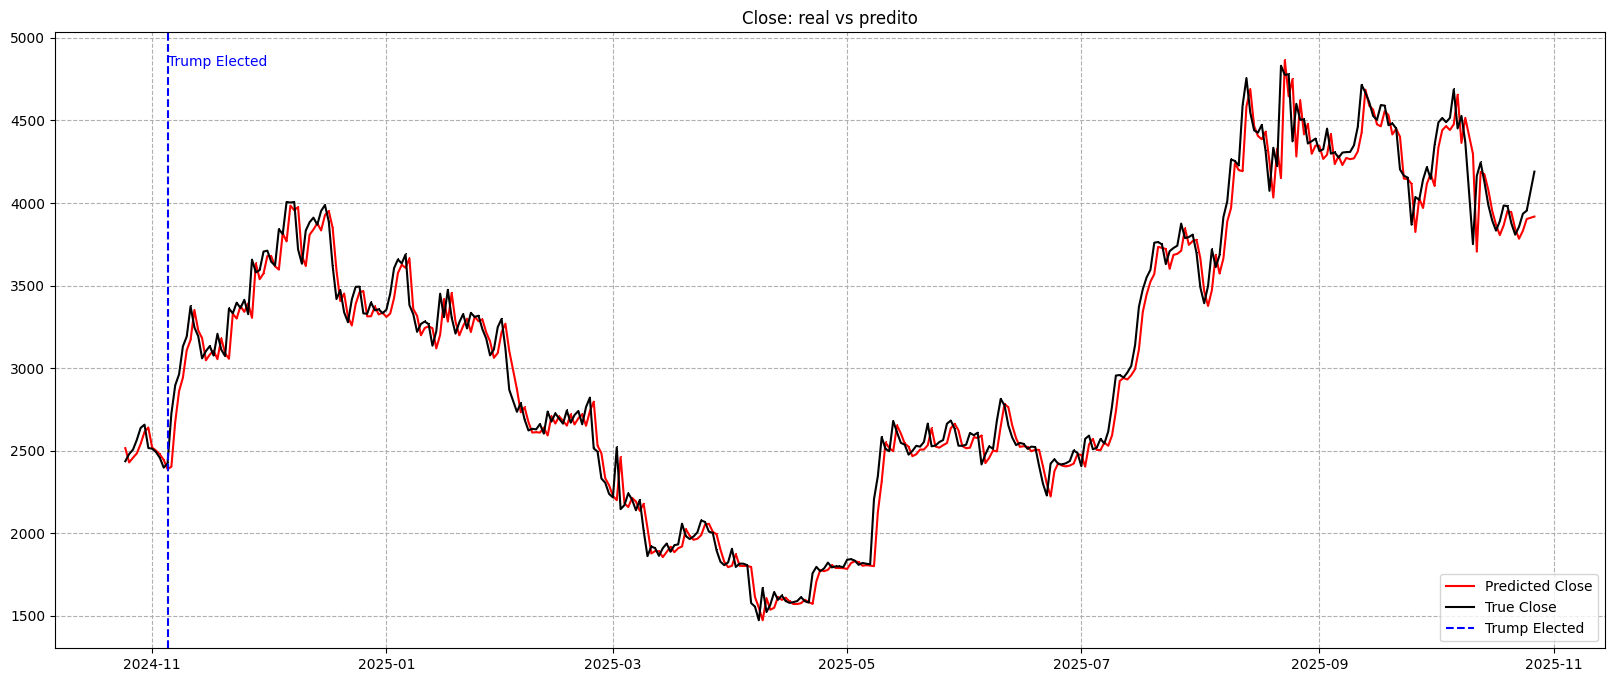

In [65]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date, color='blue', linestyle='--', label=event_label)
plt.text(event_date, max(data['Close']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

5 de novembro donald trump foi eleito presidente

### Modelo com lag nos dados completos

In [66]:
data = pd.read_csv('../../data/processed/ETH-USD_lag_all.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume,closeLag_1,closeLag_2,closeLag_3,closeLag_4,closeLag_5,...,closeLag_21,closeLag_22,closeLag_23,closeLag_24,closeLag_25,closeLag_26,closeLag_27,closeLag_28,closeLag_29,closeLag_30
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09,320.884003,329.451996,307.056000,308.644989,893249984,299.252991,314.681000,307.907990,316.716003,337.631012,...,447.114014,466.540009,463.449005,465.852997,470.204010,463.281006,428.588013,434.407990,456.031006,473.502014
2017-11-10,299.252991,324.717987,294.541992,320.670990,885985984,314.681000,307.907990,316.716003,337.631012,333.356995,...,466.540009,463.449005,465.852997,470.204010,463.281006,428.588013,434.407990,456.031006,473.502014,441.721008
2017-11-11,314.681000,319.453003,298.191986,298.585999,842300992,307.907990,316.716003,337.631012,333.356995,330.924011,...,463.449005,465.852997,470.204010,463.281006,428.588013,434.407990,456.031006,473.502014,441.721008,515.135986
2017-11-12,307.907990,319.153015,298.513000,314.690002,1613479936,316.716003,337.631012,333.356995,330.924011,332.394012,...,465.852997,470.204010,463.281006,428.588013,434.407990,456.031006,473.502014,441.721008,515.135986,651.431030
2017-11-13,316.716003,328.415009,307.024994,307.024994,1041889984,337.631012,333.356995,330.924011,332.394012,347.612000,...,470.204010,463.281006,428.588013,434.407990,456.031006,473.502014,441.721008,515.135986,651.431030,702.767029


In [67]:
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

scaler_lag = MinMaxScaler(feature_range=(0, 1))
scaler_lag.fit(train_data)

data_train_normalized = pd.DataFrame(
    scaler_lag.transform(train_data),
    columns=data.columns,
    index=train_data.index
)

data_test_normalized = pd.DataFrame(
    scaler_lag.transform(test_data),
    columns=data.columns,
    index=test_data.index
)

scaler_close_all = MinMaxScaler(feature_range=(0, 1))
scaler_close_all.fit(train_data[['Close']]) 

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [68]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  feature_cols = ['Close'] + [f'closeLag_{i}' for i in range(1, seq_len)]
  target_col = f'closeLag_{seq_len}'

  X_train_scaled = data_train_normalized[feature_cols].values
  y_train_scaled = data_train_normalized[target_col].values

  X_test_scaled = data_test_normalized[feature_cols].values
  y_test_scaled = data_test_normalized[target_col].values

  X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
  X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    grid_result_lag_all = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_lag_all.append({
      "model": grid_result_lag_all.best_estimator_,
      "params": grid_result_lag_all.best_params_,
      "rmse": -grid_result_lag_all.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "X_test": X_test_scaled,
      "y_test": y_test_scaled,
      "type": "Univariado",
      "algorithm": "LSTM"
    })
    
    print(f"Menor RMSE: {-grid_result_lag_all.best_score_:.3f} usando: {grid_result_lag_all.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.019 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 32, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.017 usando: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.016 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.016 usando: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.019 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 64, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.017 usando: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}


#### Resultados

In [69]:
for m in models_lstm_lag_all:
    y_pred = m["model"].predict(m["X_test"])
    rmse_test = np.sqrt(mean_squared_error(m["y_test"], y_pred))
    m["rmse_test"] = rmse_test

lstm_lag_all_ordered_by_test = sorted(models_lstm_lag_all, key=lambda x: x["rmse_test"])

for i, obj in enumerate(lstm_lag_all_ordered_by_test):
    print(f"--- Modelo {i+1} ---")
    print("params:", obj.get("params"))
    print("rmse_test:", obj.get("rmse_test"))
    print("n_splits:", obj.get("n_splits"))
    print("seq_len:", obj.get("seq_len"))
    print()

--- Modelo 1 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.024204870268583634
n_splits: 5
seq_len: 14

--- Modelo 2 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 64, 'model__optimizer': 'Adam'}
rmse_test: 0.024733419664502838
n_splits: 5
seq_len: 30

--- Modelo 3 ---
params: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.025159073678799708
n_splits: 10
seq_len: 14

--- Modelo 4 ---
params: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.025841277391814337
n_splits: 10
seq_len: 7

--- Modelo 5 ---
params: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.029730326682113627
n_splits: 10
seq_len: 30

--- Modelo 6 ---
pa

In [70]:
y_pred_scaled = lstm_lag_all_ordered_by_test[0]["model"].predict(lstm_lag_all_ordered_by_test[0]["X_test"])

rmse = np.sqrt(mean_squared_error(lstm_lag_all_ordered_by_test[0]["y_test"], y_pred_scaled))
mae = mean_absolute_error(lstm_lag_all_ordered_by_test[0]["y_test"], y_pred_scaled)

print(f"MAE normalizado: {mae}")
print(f"RMSE normalizado: {rmse}")

y_pred = scaler_close_all.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test = scaler_close_all.inverse_transform(lstm_lag_all_ordered_by_test[0]["y_test"].reshape(-1, 1))

y_pred = y_pred.flatten()
y_test = y_test.flatten()

MAE normalizado: 0.017135636023491534
RMSE normalizado: 0.024204870268583634


In [71]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE real: {mae}")
print(f"RMSE real: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE real: 81.0135014851888
RMSE real: 114.43527816259311
MAPE: 2.69%
R²: 0.98


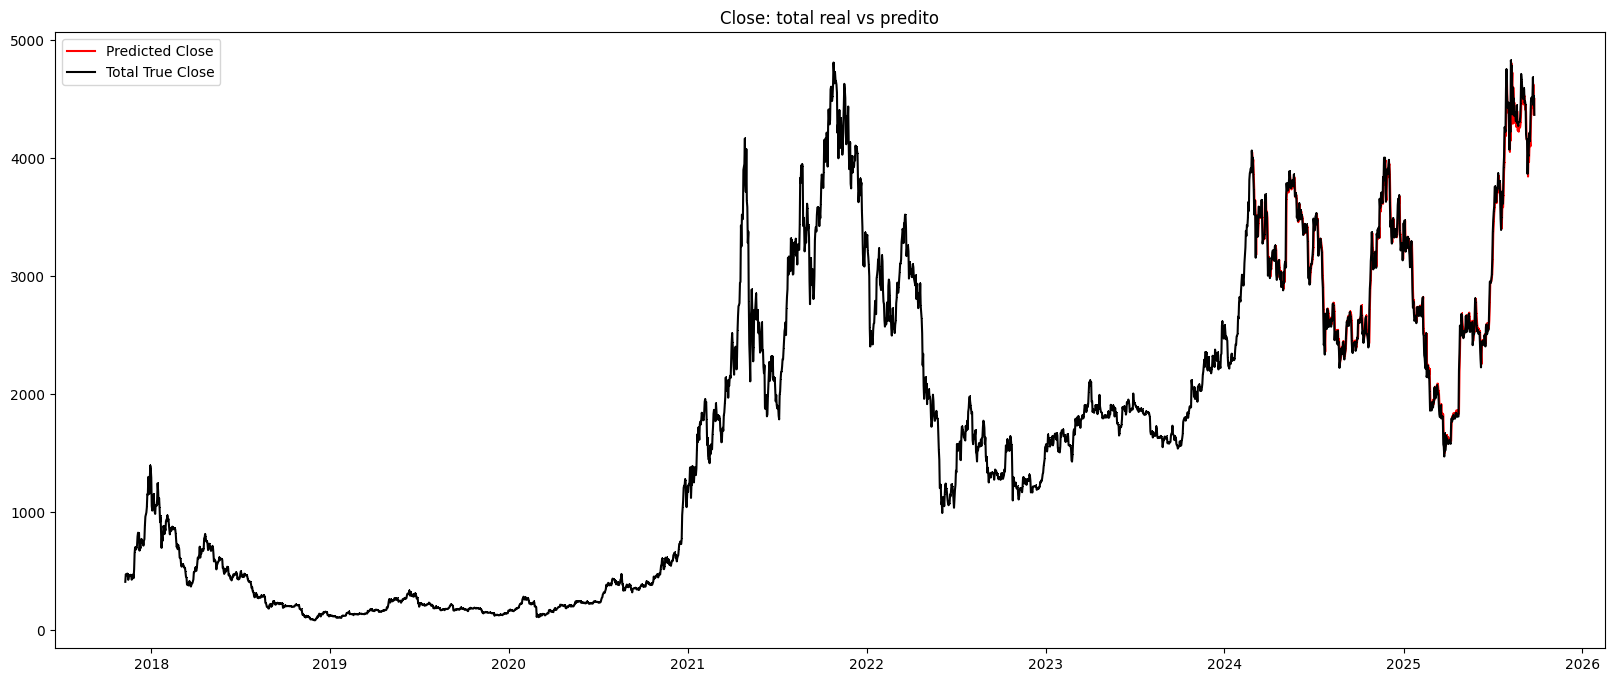

In [72]:
seq_len = lstm_lag_all_ordered_by_test[0]["seq_len"]
y_pred_plot = np.empty_like(data[f'closeLag_{seq_len}'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data[f'closeLag_{seq_len}']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

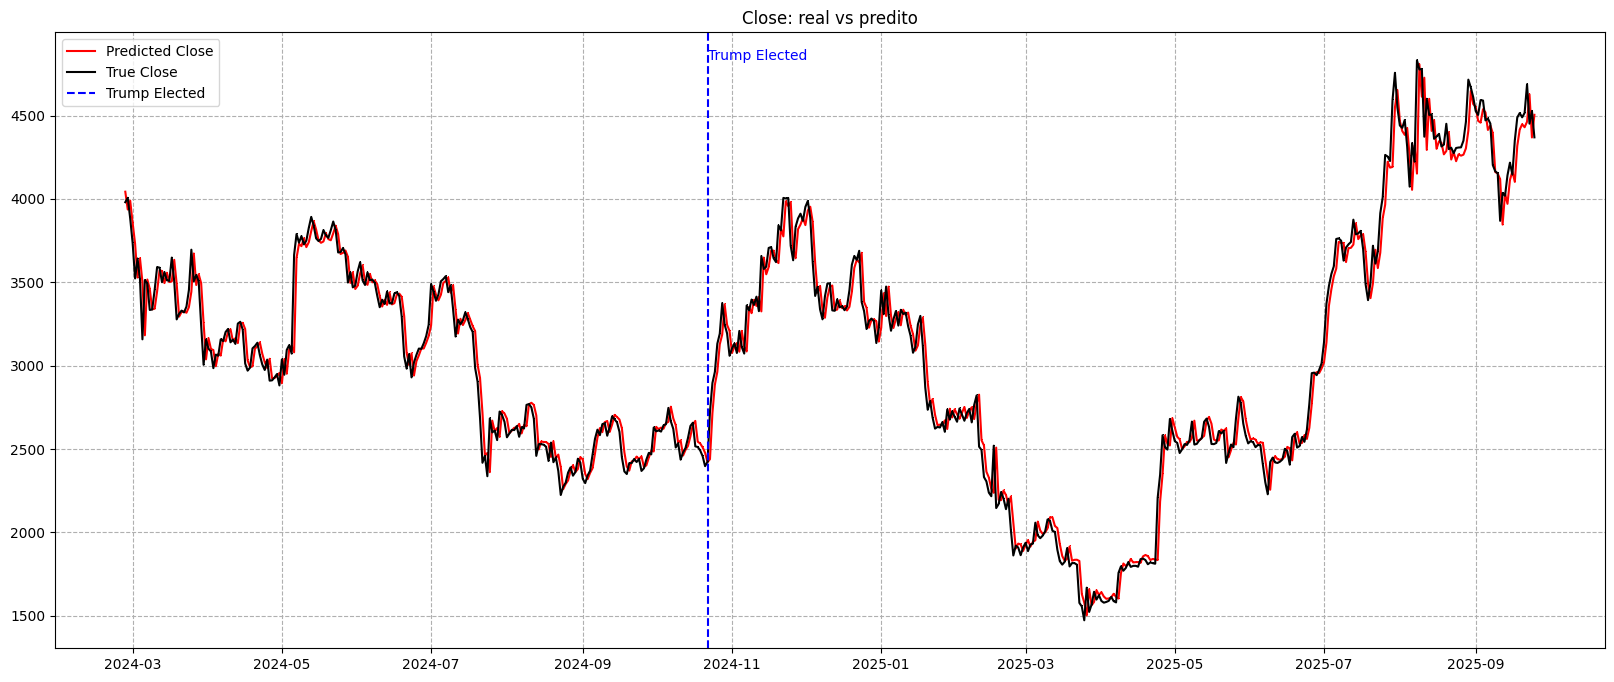

In [73]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date - pd.Timedelta(days=seq_len), color='blue', linestyle='--', label=event_label)
plt.text(event_date - pd.Timedelta(days=seq_len), max(data[f'closeLag_{seq_len}']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

### Modelo com lag nos dados cortado

In [74]:
data = pd.read_csv('../../data/processed/ETH-USD_lag_cropped.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume,closeLag_1,closeLag_2,closeLag_3,closeLag_4,closeLag_5,...,closeLag_21,closeLag_22,closeLag_23,closeLag_24,closeLag_25,closeLag_26,closeLag_27,closeLag_28,closeLag_29,closeLag_30
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-01,246.991760,248.236282,230.488052,230.860260,13951727936,237.219055,244.179321,244.426392,241.221985,241.931320,...,242.533188,244.142151,235.772461,232.944489,229.668045,222.959793,225.347168,228.194870,226.315002,231.113419
2020-06-02,237.219055,252.222000,233.225296,246.828186,13782107567,244.179321,244.426392,241.221985,241.931320,245.167252,...,244.142151,235.772461,232.944489,229.668045,222.959793,225.347168,228.194870,226.315002,231.113419,229.392197
2020-06-03,244.179321,244.179321,235.464447,237.395218,9861760817,244.426392,241.221985,241.931320,245.167252,246.309906,...,235.772461,232.944489,229.668045,222.959793,225.347168,228.194870,226.315002,231.113419,229.392197,225.387070
2020-06-04,244.426392,245.928970,236.765305,244.105286,10170414304,241.221985,241.931320,245.167252,246.309906,244.911453,...,232.944489,229.668045,222.959793,225.347168,228.194870,226.315002,231.113419,229.392197,225.387070,229.074112
2020-06-05,241.221985,247.329498,240.682053,244.349594,9293963914,241.931320,245.167252,246.309906,244.911453,247.444946,...,229.668045,222.959793,225.347168,228.194870,226.315002,231.113419,229.392197,225.387070,229.074112,227.664597


In [75]:
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

scaler_lag = MinMaxScaler(feature_range=(0, 1))
scaler_lag.fit(train_data)

data_train_normalized = pd.DataFrame(
    scaler_lag.transform(train_data),
    columns=data.columns,
    index=train_data.index
)

data_test_normalized = pd.DataFrame(
    scaler_lag.transform(test_data),
    columns=data.columns,
    index=test_data.index
)

scaler_close_cropped = MinMaxScaler(feature_range=(0, 1))
scaler_close_cropped.fit(train_data[['Close']]) 

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [76]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  feature_cols = ['Close'] + [f'closeLag_{i}' for i in range(1, seq_len)]
  target_col = f'closeLag_{seq_len}'

  X_train_scaled = data_train_normalized[feature_cols].values
  y_train_scaled = data_train_normalized[target_col].values

  X_test_scaled = data_test_normalized[feature_cols].values
  y_test_scaled = data_test_normalized[target_col].values

  X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
  X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    grid_result_lag_cropped = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_lag_cropped.append({
      "model": grid_result_lag_cropped.best_estimator_,
      "params": grid_result_lag_cropped.best_params_,
      "rmse": -grid_result_lag_cropped.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "X_test": X_test_scaled,
      "y_test": y_test_scaled,
      "type": "Univariado",
      "algorithm": "LSTM"
    })
    
    print(f"Menor RMSE: {-grid_result_lag_cropped.best_score_:.3f} usando: {grid_result_lag_cropped.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.026 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.026 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.074 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.027 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.029 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.030 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}


#### Resultados

In [77]:
for m in models_lstm_lag_cropped:
    y_pred = m["model"].predict(m["X_test"])
    rmse_test = np.sqrt(mean_squared_error(m["y_test"], y_pred))
    m["rmse_test"] = rmse_test

lstm_lag_cropped_ordered_by_test = sorted(models_lstm_lag_cropped, key=lambda x: x["rmse_test"])

for i, obj in enumerate(lstm_lag_cropped_ordered_by_test):
    print(f"--- Modelo {i+1} ---")
    print("params:", obj.get("params"))
    print("rmse_test:", obj.get("rmse_test"))
    print("n_splits:", obj.get("n_splits"))
    print("seq_len:", obj.get("seq_len"))
    print()

--- Modelo 1 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.025641310504074147
n_splits: 10
seq_len: 14

--- Modelo 2 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.026494623017517472
n_splits: 5
seq_len: 7

--- Modelo 3 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.026907229786947085
n_splits: 10
seq_len: 30

--- Modelo 4 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.029935046507391157
n_splits: 10
seq_len: 7

--- Modelo 5 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.030967141339847563
n_splits: 5
seq_len: 14

--- Modelo 6 ---
pa

In [78]:
y_pred_scaled = lstm_lag_cropped_ordered_by_test[0]["model"].predict(lstm_lag_cropped_ordered_by_test[0]["X_test"])

rmse = np.sqrt(mean_squared_error(lstm_lag_cropped_ordered_by_test[0]["y_test"], y_pred_scaled))
mae = mean_absolute_error(lstm_lag_cropped_ordered_by_test[0]["y_test"], y_pred_scaled)

print(f"MAE normalizado: {mae}")
print(f"RMSE normalizado: {rmse}")

y_pred = scaler_close_cropped.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test = scaler_close_cropped.inverse_transform(lstm_lag_cropped_ordered_by_test[0]["y_test"].reshape(-1, 1))

y_pred = y_pred.flatten()
y_test = y_test.flatten()

MAE normalizado: 0.018236472922389366
RMSE normalizado: 0.025641310504074147


In [79]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE real: {mae}")
print(f"RMSE real: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE real: 83.68950113723088
RMSE real: 117.67125347271111
MAPE: 2.79%
R²: 0.98


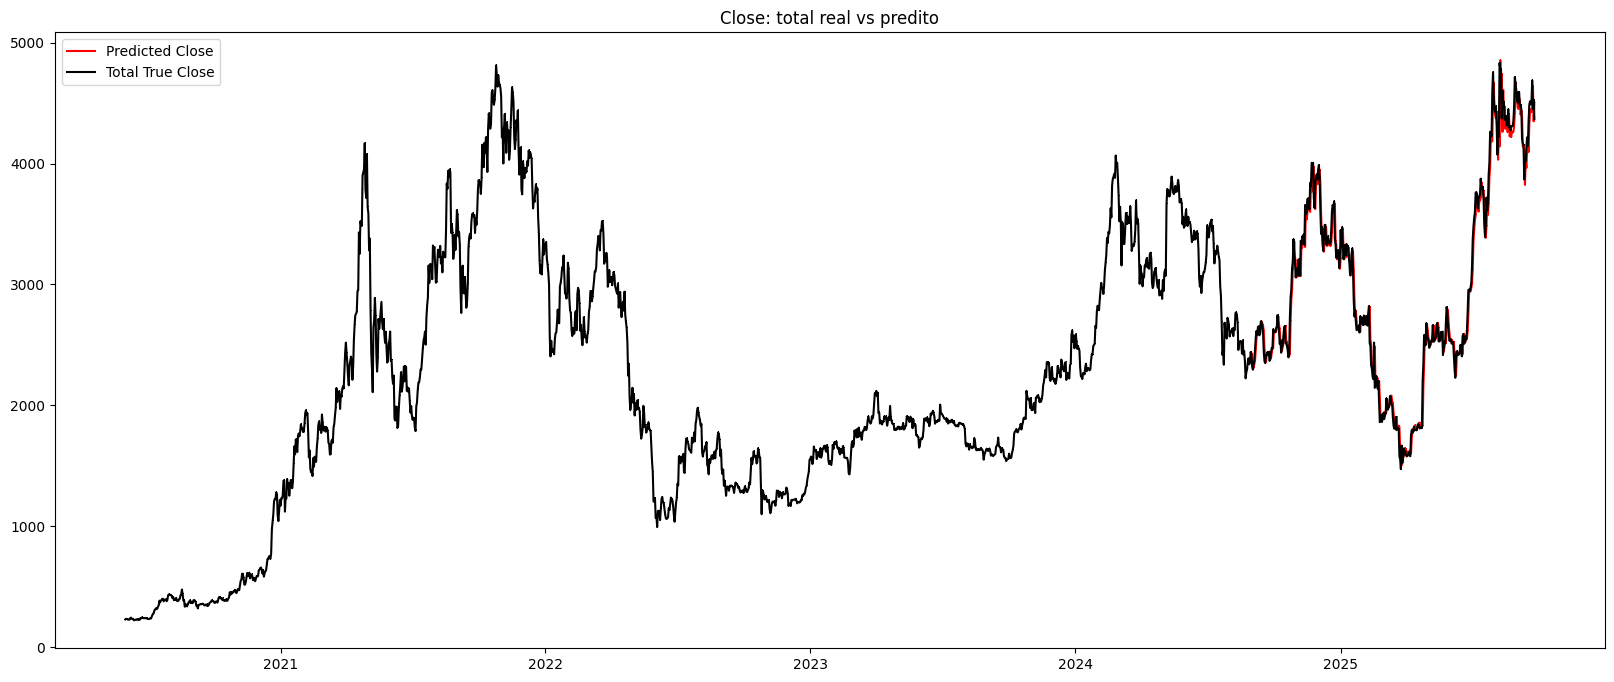

In [80]:
seq_len = lstm_lag_cropped_ordered_by_test[0]["seq_len"]
y_pred_plot = np.empty_like(data[f'closeLag_{seq_len}'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data[f'closeLag_{seq_len}']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

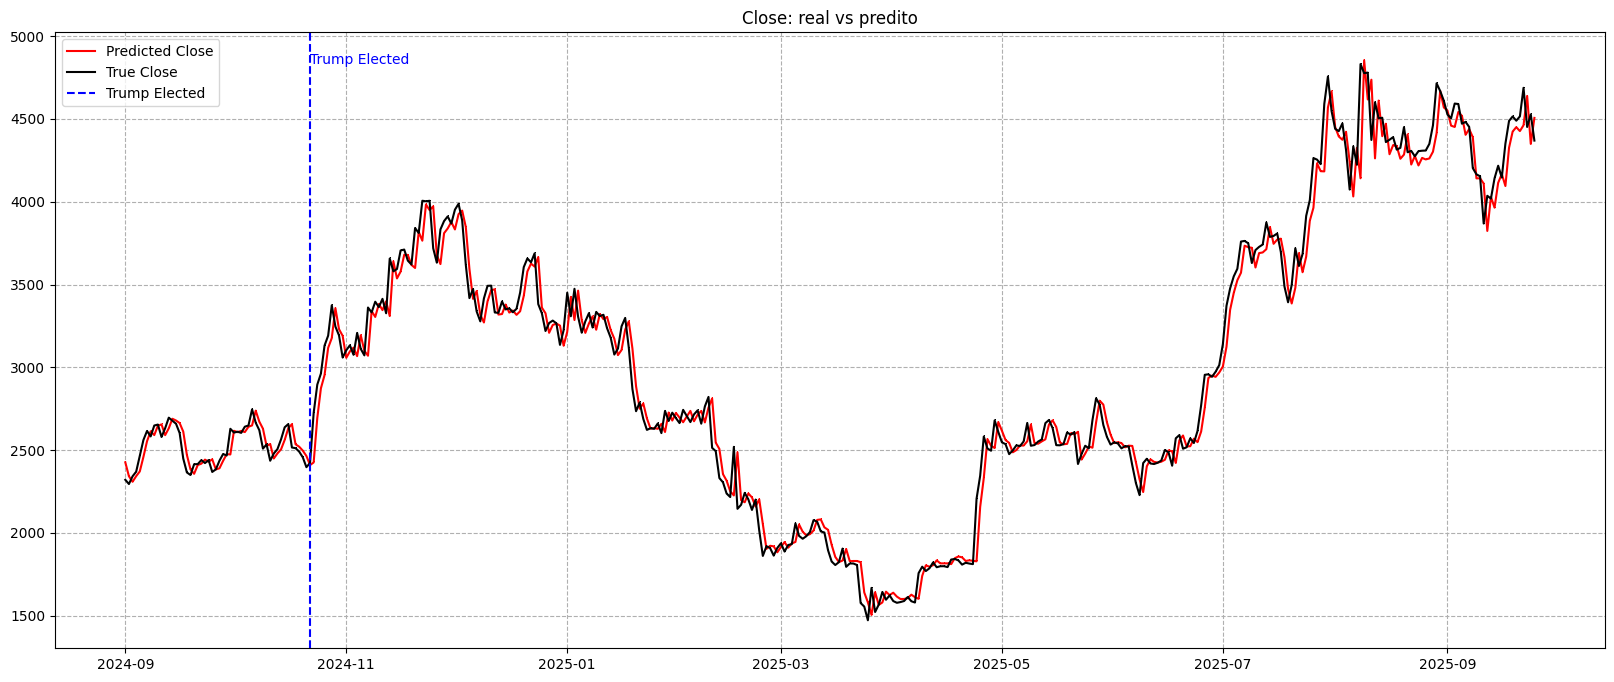

In [81]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date - pd.Timedelta(days=seq_len), color='blue', linestyle='--', label=event_label)
plt.text(event_date - pd.Timedelta(days=seq_len), max(data[f'closeLag_{seq_len}']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()